In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

## config

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]


In [3]:
EXP_NAME

'exp021'

## read data

In [4]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'2kaido_wifi_dataset_v2/train_20000_7.pkl', 'rb') as f:
  train_df = pickle.load(f)

with open(root_dir/'2kaido_wifi_dataset_v2/test_20000_7.pkl', 'rb') as f:
  test_df = pickle.load(f)

oof = pd.read_csv('oof.csv')

In [5]:
train_df = train_df.astype({'timestamp':int,'x': np.float32, 'y': np.float32, 'floor':np.float32, 'ix':np.float32, 'iy':np.float32, 'timediff':np.int})
test_df = test_df.astype({'timestamp':int})
train_df['site_path_timestamp'] = train_df['site_id'] + "_" + train_df['path'] + '_' + train_df['timestamp'].astype(str)

## スコア(error)を計算

In [6]:
def mean_position_error(xhat, yhat, x, y):
    return np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2))

In [7]:
def metric(row):
    return mean_position_error(row['oof_x'], row['oof_y'], row['x'], row['y'])

In [8]:
oof['error'] = oof.apply(metric, axis=1)

In [9]:
oof['error'].mean()

7.377872848800126

In [23]:
thr = 40
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', len(oof.loc[oof['error']>thr]))
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())
np.save(root_dir/f'{thr}s_over_path', oof.loc[oof['error']>thr, 'path'].unique())

7.300647018123598
データ数 423
path数 92


In [24]:
thr = 30
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', len(oof.loc[oof['error']>thr]))
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())
np.save(root_dir/f'{thr}s_over_path', oof.loc[oof['error']>thr, 'path'].unique())

7.173773333442471
データ数 1650
path数 301


In [25]:
thr = 20
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', len(oof.loc[oof['error']>thr]))
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())
np.save(root_dir/f'{thr}s_over_path', oof.loc[oof['error']>thr, 'path'].unique())

6.736938962872808
データ数 8264
path数 1273


<AxesSubplot:>

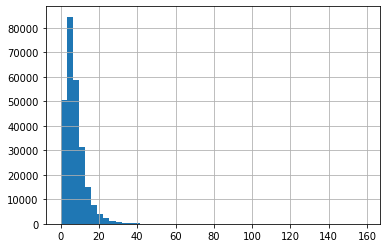

In [9]:
oof['error'].hist(bins=50)

(0.0, 200.0)

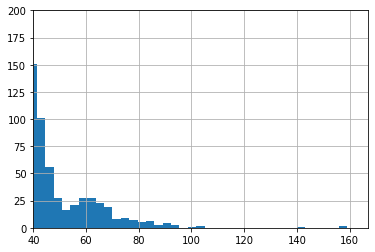

In [14]:
oof['error'].hist(bins=50)
plt.xlim(40,)
plt.ylim(0,200)

かなり外れているのもある
40以上の外れ値ってどうなっているの？どういうpathが存在している？

In [11]:
oof.loc[oof['error']>40, 'path']  # このpath消すってのもありかも

1647      5d11dc1bffe23f0008604f65
1651      5d11dc1bffe23f0008604f65
1652      5d11dc1bffe23f0008604f65
1653      5d11dc1bffe23f0008604f65
1655      5d11dc1bffe23f0008604f65
                    ...           
250539    5dcf885794e49000061256c2
250540    5dcf885794e49000061256c2
250541    5dcf885794e49000061256c2
250542    5dcf885794e49000061256c2
250543    5dcf885794e49000061256c2
Name: path, Length: 423, dtype: object

In [18]:
oof.loc[oof['error']>40, 'path'].nunique()

92

In [12]:
oof.loc[oof['error']>40, 'path'].value_counts().values  # 数はどれくらい

array([41, 32, 27, 26, 22, 21, 14, 12,  9,  8,  8,  7,  7,  7,  7,  6,  6,
        6,  6,  6,  5,  5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1])

pathごとに見てみると同一pathで全体的に外しているものが10個くらいある。path内のデータのうちどれくらいのデータが40オーバーになっているか調査する

<AxesSubplot:>

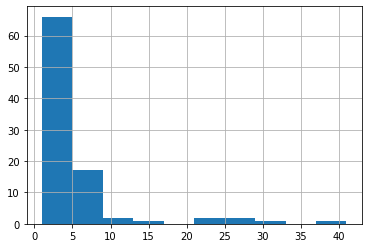

In [19]:
oof.loc[oof['error']>40, 'path'].value_counts().hist()

In [20]:
path = oof.loc[oof['error']>40, 'path'].value_counts().index
num_data_over40 = oof.loc[oof['error']>40, 'path'].value_counts().values
num_data = []
for i in path:
    num_data.append(len(oof[oof['path']==i]))

(array([60., 16.,  5.,  3.,  2.,  2.,  0.,  0.,  1.,  3.]),
 array([0.0037594 , 0.10338346, 0.20300752, 0.30263158, 0.40225564,
        0.5018797 , 0.60150376, 0.70112782, 0.80075188, 0.90037594,
        1.        ]),
 <BarContainer object of 10 artists>)

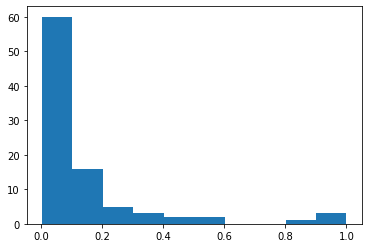

In [21]:
plt.hist(num_data_over40 / num_data)

path丸ごと外しているものもある

In [34]:
import json
import matplotlib.pylab as plt

def plot_preds(
    example,
    base=str(root_dir /'indoor-location-navigation'),
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    site = example.loc[0, 'site_id_str']
    map_floor = example.loc[0, 'floor_str']
    path = example.loc[0, 'path']
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title(f'site={site} | floor={map_floor} | path={path}', fontsize=15)
    plt.imshow(floor_img)


    example["x_"] = example["x"] * floor_img.shape[0] / height_meter
    example["y_"] = (example["y"] * -1 * floor_img.shape[1] / width_meter) + floor_img.shape[0]


    example["oof_x_"] = example["oof_x"] * floor_img.shape[0] / height_meter
    example["oof_y_"] = (example["oof_y"] * -1 * floor_img.shape[1] / width_meter) + floor_img.shape[0]

    example.plot(
        x="x_",
        y="y_",
        style=".-",
        ax=ax,
        alpha=0.5,
        label='target'
    )
    example.plot(
        x="oof_x_",
        y="oof_y_",
        style=".-",
        ax=ax,
        alpha=0.5,
        label='oof'
    )
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(
        by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5),fontsize=20
    )
    return fig, ax

In [35]:
np.where((num_data_over40 / num_data) > 0.5)  # 半分以上おかしいものを取得

(array([ 0,  2,  6, 11, 14, 23]),)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'site=5d2709b303f801723c327472 | floor=1F | path=5dac211d18410e00067e7121'}, xlabel='oof_x_'>)

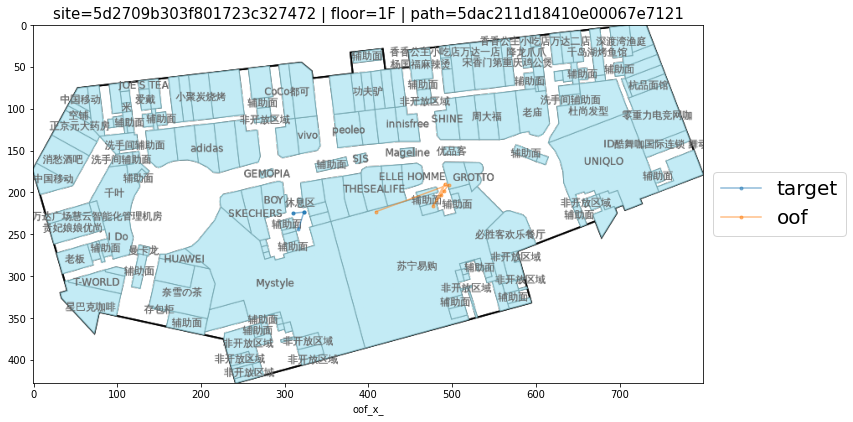

In [41]:
example = oof[oof['path']==path[23]].reset_index()
plot_preds(example)

In [47]:
df = pd.merge(oof.groupby('site_path_timestamp').mean(), train_df.groupby('site_path_timestamp')[['timediff']].mean(), how='left', on='site_path_timestamp')

Text(0, 0.5, 'error')

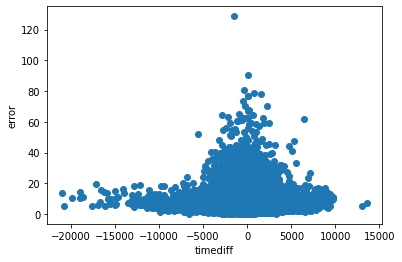

In [50]:
x = df['timediff']
y = df['error']
plt.scatter(x,y)
plt.xlabel('timediff')
plt.ylabel('error')